In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.5 MB/s eta 0:00:00


In [ ]:
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:

ref_image_path = "/content/drive/MyDrive/DSM/NDVI_2018_2024_Median.tif"

CRS: EPSG:4326
Resolution: (8.983152841195215e-05, 8.983152841195215e-05)
Bounds (Extent): BoundingBox(left=78.17193501325123, bottom=30.284454015879366, right=78.309916240892, top=30.41938097155412)
Number of Bands: 1
Band Descriptions: ('NDVI_2018_2024',)
Width x Height: 1536 x 1502


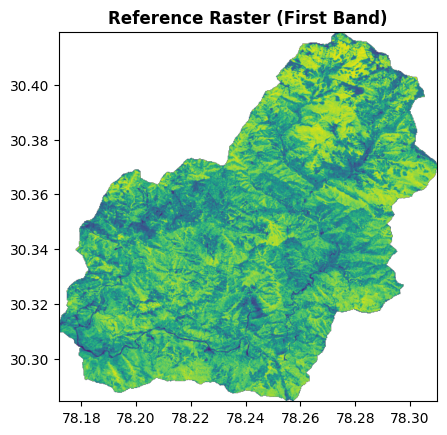

In [ ]:
# Open and inspect the raster
with rasterio.open(ref_image_path) as ref_image:
    ref_crs = ref_image.crs
    ref_transform = ref_image.transform
    ref_width = ref_image.width
    ref_height = ref_image.height
    ref_bounds = ref_image.bounds
    ref_res = ref_image.res

    print("CRS:", ref_crs)
    print("Resolution:", ref_res)
    print("Bounds (Extent):", ref_bounds)
    print("Number of Bands:", ref_image.count)
    print("Band Descriptions:", ref_image.descriptions)
    print("Width x Height:", ref_width, "x", ref_height)
    show(ref_image, title="Reference Raster (First Band)")

In [ ]:
# Covariate raster paths
covariate_paths = {
    "ann_ppt": "/content/drive/MyDrive/DSM/median_r.tif",
    "aspect_cos": "/content/drive/MyDrive/DSM/aspect.tif",
    "brightness_tc": "/content/drive/MyDrive/DSM/Median_BI_2017_2024.tif",
    "carbonate": "/content/drive/MyDrive/DSM/carbonate.tif",
    "clay": "/content/drive/MyDrive/DSM/clay.tif",

    "cti": "/content/drive/MyDrive/DSM/cti.tif",
    "elevation": "/content/drive/MyDrive/DSM/elevation.tif",
    "fa": "/content/drive/MyDrive/DSM/fa.tif",
    "ferrous": "/content/drive/MyDrive/DSM/ferrous.tif",
    "geology": "/content/drive/MyDrive/DSM/geology.tif",

    "iron": "/content/drive/MyDrive/DSM/iron.tif",
    "lulc": "/content/drive/MyDrive/DSM/lulc_d.tif",#####
    "mean_ndvi": "/content/drive/MyDrive/DSM/NDVI_2018_2024_Median.tif",
    "plan_curv": "/content/drive/MyDrive/DSM/plan_curv.tif",
    "prof_curv": "/content/drive/MyDrive/DSM/prof_curv.tif",
    "slope": "/content/drive/MyDrive/DSM/slope.tif",
    "solar_radiation": "/content/drive/MyDrive/DSM/solar_rad.tif",
    "lst_median" : "/content/drive/MyDrive/DSM/median_lst.tif",
    "wetness": "/content/drive/MyDrive/DSM/wetness.tif"
}


In [ ]:
output_dir = "/content/drive/MyDrive/DSM"
os.makedirs(output_dir, exist_ok=True)


In [ ]:
aligned_paths = {}

for name, input_path in covariate_paths.items():
    output_path = os.path.join(output_dir, f"{name}_aligned.tif")
    with rasterio.open(input_path) as src:
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': ref_crs,
            'transform': ref_transform,
            'width': ref_width,
            'height': ref_height,
            'count' : src.count
        })

        with rasterio.open(output_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=ref_transform,
                    dst_crs=ref_crs,
                    resampling=Resampling.bilinear
                )

        with rasterio.open(output_path, 'r+') as dst:
            window = from_bounds(*ref_bounds, transform=dst.transform)
            cropped = dst.read(window=window)
            dst.write(cropped)

    print(f"Aligned and cropped {name} to {output_path}")
    aligned_paths[name] = output_path

Aligned and cropped ann_ppt to /content/drive/MyDrive/DSM/ann_ppt_aligned.tif
Aligned and cropped aspect_cos to /content/drive/MyDrive/DSM/aspect_cos_aligned.tif
Aligned and cropped brightness_tc to /content/drive/MyDrive/DSM/brightness_tc_aligned.tif
Aligned and cropped carbonate to /content/drive/MyDrive/DSM/carbonate_aligned.tif
Aligned and cropped clay to /content/drive/MyDrive/DSM/clay_aligned.tif
Aligned and cropped cti to /content/drive/MyDrive/DSM/cti_aligned.tif
Aligned and cropped elevation to /content/drive/MyDrive/DSM/elevation_aligned.tif
Aligned and cropped fa to /content/drive/MyDrive/DSM/fa_aligned.tif
Aligned and cropped ferrous to /content/drive/MyDrive/DSM/ferrous_aligned.tif
Aligned and cropped geology to /content/drive/MyDrive/DSM/geology_aligned.tif
Aligned and cropped iron to /content/drive/MyDrive/DSM/iron_aligned.tif
Aligned and cropped lulc to /content/drive/MyDrive/DSM/lulc_aligned.tif
Aligned and cropped mean_ndvi to /content/drive/MyDrive/DSM/mean_ndvi_alig

In [ ]:
stack_output_path = os.path.join(output_dir, "covariate_stack.tif")
with rasterio.open(aligned_paths[next(iter(aligned_paths))]) as first:
    meta = first.meta.copy()
    meta.update(count=len(aligned_paths))

    with rasterio.open(stack_output_path, 'w', **meta) as dst:
        for idx, (name, path) in enumerate(aligned_paths.items(), start=1):
            with rasterio.open(path) as src:
                dst.write(src.read(1), idx)
                dst.set_band_description(idx, name)

print(f"Stacked raster saved at {stack_output_path}")

Stacked raster saved at /content/drive/MyDrive/DSM/covariate_stack.tif


In [ ]:
obs_csv_path = "/content/dhanolti_surface_trimmed.csv"
obs_df = pd.read_csv(obs_csv_path)
geometry = [Point(xy) for xy in zip(obs_df["long"], obs_df["lat"])]
obs_gdf = gpd.GeoDataFrame(obs_df, geometry=geometry, crs="EPSG:4326")
obs_gdf = obs_gdf.to_crs(ref_crs)

In [ ]:
print(f"Number of observations: {len(obs_gdf)}")


Number of observations: 80


In [ ]:
print(obs_gdf)

    Unnamed: 0  Sno       long        lat     pH       EC   Sand   Clay  \
0            0    1  78.208182  30.362100  4.482  0.08246  22.64  26.08   
1            1    2  78.201415  30.351840  4.125  0.05563  32.64  20.08   
2            2    3  78.213223  30.359735  4.985  0.20060  42.64  18.08   
3            3    4  78.216995  30.359980  5.183  0.12950  38.64  20.08   
4            4    5  78.216219  30.367034  4.812  0.11080  40.64  22.08   
..         ...  ...        ...        ...    ...      ...    ...    ...   
75          75   76  78.182979  30.293101  5.914  0.09013  38.80  30.64   
76          76   77  78.231272  30.303366  6.276  0.16000  30.44  23.92   
77          77   78  78.182798  30.301682  5.385  0.15990  42.44  29.92   
78          78   79  78.246927  30.293185  5.548  0.11250  47.52  23.92   
79          79   80  78.197150  30.291434  5.634  0.06250  33.52  27.92   

     Silt       TOC     Soil P  Avail K  Nitrogen                   geometry  
0   51.28  2.442424 

In [ ]:
"""with rasterio.open(stack_output_path) as src:
    values = list(src.sample([(pt.x, pt.y) for pt in obs_gdf.geometry]))
    values_df = pd.DataFrame(values, columns=[desc if desc else f"Band_{i+1}"
                                               for i, desc in enumerate(src.descriptions)])
    extracted_df = pd.concat([obs_df, values_df], axis=1)"""

'with rasterio.open(stack_output_path) as src:\n    values = list(src.sample([(pt.x, pt.y) for pt in obs_gdf.geometry]))\n    values_df = pd.DataFrame(values, columns=[desc if desc else f"Band_{i+1}" \n                                               for i, desc in enumerate(src.descriptions)])\n    extracted_df = pd.concat([obs_df, values_df], axis=1)'

In [ ]:
with rasterio.open(stack_output_path) as src:
    values = list(src.sample([(pt.x, pt.y) for pt in obs_gdf.geometry]))
    values_df = pd.DataFrame(values, columns=list(aligned_paths.keys()))
    print(values_df.columns)

    extracted_df = pd.concat([obs_df, values_df], axis=1)

Index(['ann_ppt', 'aspect_cos', 'brightness_tc', 'carbonate', 'clay', 'cti',
       'elevation', 'fa', 'ferrous', 'geology', 'iron', 'lulc', 'mean_ndvi',
       'plan_curv', 'prof_curv', 'slope', 'solar_radiation', 'lst_median',
       'wetness'],
      dtype='object')


In [ ]:
print(extracted_df)
print(extracted_df.shape)

    Unnamed: 0  Sno       long        lat     pH       EC   Sand   Clay  \
0            0    1  78.208182  30.362100  4.482  0.08246  22.64  26.08   
1            1    2  78.201415  30.351840  4.125  0.05563  32.64  20.08   
2            2    3  78.213223  30.359735  4.985  0.20060  42.64  18.08   
3            3    4  78.216995  30.359980  5.183  0.12950  38.64  20.08   
4            4    5  78.216219  30.367034  4.812  0.11080  40.64  22.08   
..         ...  ...        ...        ...    ...      ...    ...    ...   
75          75   76  78.182979  30.293101  5.914  0.09013  38.80  30.64   
76          76   77  78.231272  30.303366  6.276  0.16000  30.44  23.92   
77          77   78  78.182798  30.301682  5.385  0.15990  42.44  29.92   
78          78   79  78.246927  30.293185  5.548  0.11250  47.52  23.92   
79          79   80  78.197150  30.291434  5.634  0.06250  33.52  27.92   

     Silt       TOC  ...  geology  iron  lulc  mean_ndvi  plan_curv  \
0   51.28  2.442424  ...    

In [ ]:


extracted_df.to_csv('extracted_data2.csv', index=False)


In [ ]:
zero_percentages = (extracted_df == 0).sum() * 100 / len(extracted_df)
zero_percentages


,0
Unnamed: 0,1.25
Sno,0.00
long,0.00
lat,0.00
pH,0.00
EC,0.00
Sand,0.00
Clay,0.00
Silt,0.00
TOC,0.00


In [ ]:
with rasterio.open(stack_output_path) as src:
    # Print column names directly from rasterio descriptions
    print("Column Names:")
    for i, desc in enumerate(src.descriptions):
        print(desc if desc else f"Band_{i+1}")
    values = list(src.sample([(pt.x, pt.y) for pt in obs_gdf.geometry]))
    values_df = pd.DataFrame(values, columns=[desc if desc else f"Band_{i+1}"
                                               for i, desc in enumerate(src.descriptions)])
    extracted_df = pd.concat([obs_df, values_df], axis=1)
print(extracted_df)
extracted_df.shape


Column Names:
ann_ppt
aspect_cos
brightness_tc
carbonate
clay
cti
elevation
fa
ferrous
geology
iron
lulc
mean_ndvi
plan_curv
prof_curv
slope
solar_radiation
lst_median
wetness
    Unnamed: 0  Sno       long        lat     pH       EC   Sand   Clay  \
0            0    1  78.208182  30.362100  4.482  0.08246  22.64  26.08   
1            1    2  78.201415  30.351840  4.125  0.05563  32.64  20.08   
2            2    3  78.213223  30.359735  4.985  0.20060  42.64  18.08   
3            3    4  78.216995  30.359980  5.183  0.12950  38.64  20.08   
4            4    5  78.216219  30.367034  4.812  0.11080  40.64  22.08   
..         ...  ...        ...        ...    ...      ...    ...    ...   
75          75   76  78.182979  30.293101  5.914  0.09013  38.80  30.64   
76          76   77  78.231272  30.303366  6.276  0.16000  30.44  23.92   
77          77   78  78.182798  30.301682  5.385  0.15990  42.44  29.92   
78          78   79  78.246927  30.293185  5.548  0.11250  47.52  23.92   

(80, 32)

**Prediciton for PH model**


In [ ]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

# Load the data
extracted_df = pd.read_csv("/content/extracted_data2.csv")

# Set target and selected features
target = "pH"
selected_features = [
    "ann_ppt", "aspect_cos", "brightness_tc", "carbonate", "clay", "cti",
    "elevation", "fa", "ferrous", "geology", "iron", "lulc", "mean_ndvi",
    "plan_curv", "prof_curv", "slope", "solar_radiation", "lst_median", "wetness"
]

# Drop rows with missing pH values
extracted_df.dropna(subset=[target], inplace=True)

# Fill missing values in features with median
extracted_df[selected_features] = extracted_df[selected_features].fillna(extracted_df[selected_features].median())

# Feature scaling (z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(extracted_df[selected_features])
y = extracted_df[target].values

# Feature importance for pruning
model_temp = RandomForestRegressor(random_state=42)
model_temp.fit(X_scaled, y)
importance_df = pd.DataFrame({"Feature": selected_features, "Importance": model_temp.feature_importances_})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
important_features = importance_df["Feature"].head(15).tolist()

X = extracted_df[important_features]
X = scaler.fit_transform(X)

# K-Fold Cross-Validation
n_splits = 6  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_results = []
saved_model = None

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Hyperparameter tuning within each fold
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_


Fold 1:
  Training R2: 0.7223
  Testing R2: -0.4445
  Training RMSE: 0.3581
  Testing RMSE: 0.7059
Fold 2:
  Training R2: 0.6870
  Testing R2: -0.1066
  Training RMSE: 0.3704
  Testing RMSE: 0.7102
Fold 3:
  Training R2: 0.7475
  Testing R2: -0.2383
  Training RMSE: 0.3004
  Testing RMSE: 1.0432
Fold 4:
  Training R2: 0.8416
  Testing R2: -0.1182
  Training RMSE: 0.2733
  Testing RMSE: 0.5927
Fold 5:
  Training R2: 0.7802
  Testing R2: 0.4958
  Training RMSE: 0.3328
  Testing RMSE: 0.2742
Fold 6:
  Training R2: 0.7101
  Testing R2: 0.0752
  Training RMSE: 0.3574
  Testing RMSE: 0.6495



Overall K-Fold Results:
    fold  train_r2   test_r2  train_rmse  test_rmse
0     1  0.722296 -0.444523    0.358132   0.705851
1     2  0.687008 -0.106591    0.370408   0.710160
2     3  0.747514 -0.238346    0.300351   1.043177
3     4  0.841595 -0.118211    0.273344   0.592744
4     5  0.780151  0.495784    0.332770   0.274214
5     6  0.710077  0.075238    0.357369   0.649512


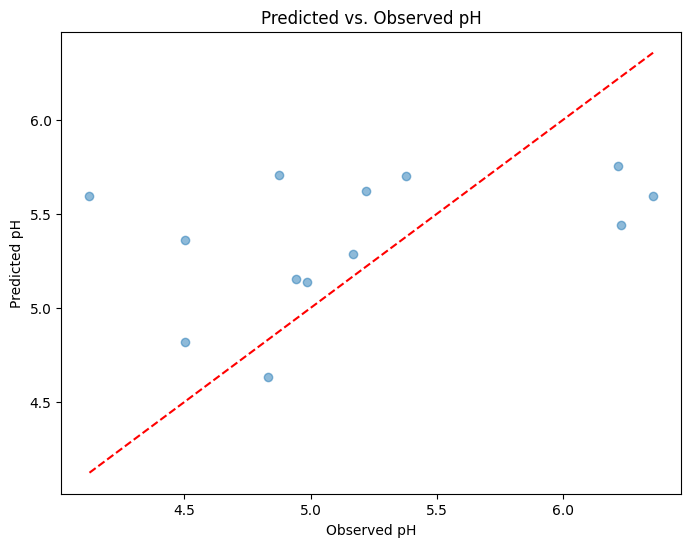

In [ ]:
import pickle
import os

# Save the model from fold 5
if saved_model is not None:
    with open("ph_prediction_model_fold5_new.pkl", "wb") as file:
        pickle.dump(saved_model, file)

# Log and visualize results
results_df = pd.DataFrame(fold_results)
print("\nOverall K-Fold Results:\n", results_df)

# Visualize Predicted vs. Observed pH
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_preds, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal line
plt.xlabel("Observed pH")
plt.ylabel("Predicted pH")
plt.title("Predicted vs. Observed pH")
plt.show()



**Predicition for EC**

In [ ]:
# Load the data
extracted_df = pd.read_csv("/content/extracted_data2.csv")

# Set target and selected features
target = "EC"
selected_features = [
    "ann_ppt", "aspect_cos", "brightness_tc", "carbonate", "clay", "cti",
    "elevation", "fa", "ferrous", "geology", "iron", "lulc", "mean_ndvi",
    "plan_curv", "prof_curv", "slope", "solar_radiation", "lst_median", "wetness"
]

# Drop rows with missing pH values
extracted_df.dropna(subset=[target], inplace=True)

# Fill missing values in features with median
extracted_df[selected_features] = extracted_df[selected_features].fillna(extracted_df[selected_features].median())

# Feature scaling (z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(extracted_df[selected_features])
y = extracted_df[target].values

# Feature importance for pruning
model_temp = RandomForestRegressor(random_state=42)
model_temp.fit(X_scaled, y)
importance_df = pd.DataFrame({"Feature": selected_features, "Importance": model_temp.feature_importances_})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
important_features = importance_df["Feature"].head(15).tolist()

X = extracted_df[important_features]
X = scaler.fit_transform(X)

# K-Fold Cross-Validation
n_splits = 6  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_results = []
saved_model = None

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Hyperparameter tuning within each fold
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Train and evaluate the model
    best_model.fit(X_train, y_train)
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)

    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    fold_results.append({
        'fold': fold + 1,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    })

    if fold + 1 == 3:
        saved_model = best_model

    print(f"Fold {fold + 1}:")
    print(f"  Training R2: {train_r2:.4f}")
    print(f"  Testing R2: {test_r2:.4f}")
    print(f"  Training RMSE: {train_rmse:.4f}")
    print(f"  Testing RMSE: {test_rmse:.4f}")



Fold 1:
  Training R2: 0.7859
  Testing R2: -0.1360
  Training RMSE: 0.0408
  Testing RMSE: 0.0892
Fold 2:
  Training R2: 0.8922
  Testing R2: 0.1041
  Training RMSE: 0.0260
  Testing RMSE: 0.1129
Fold 3:
  Training R2: 0.7577
  Testing R2: 0.4343
  Training RMSE: 0.0422
  Testing RMSE: 0.0723
Fold 4:
  Training R2: 0.8553
  Testing R2: -0.2073
  Training RMSE: 0.0352
  Testing RMSE: 0.0603
Fold 5:
  Training R2: 0.7962
  Testing R2: 0.2080
  Training RMSE: 0.0401
  Testing RMSE: 0.0707
Fold 6:
  Training R2: 0.7607
  Testing R2: 0.3866
  Training RMSE: 0.0442
  Testing RMSE: 0.0544



Overall K-Fold Results:
    fold  train_r2   test_r2  train_rmse  test_rmse
0     1  0.785917 -0.136009    0.040787   0.089177
1     2  0.892237  0.104146    0.026019   0.112898
2     3  0.757746  0.434328    0.042208   0.072257
3     4  0.855323 -0.207309    0.035229   0.060289
4     5  0.796249  0.207972    0.040142   0.070735
5     6  0.760701  0.386605    0.044206   0.054426


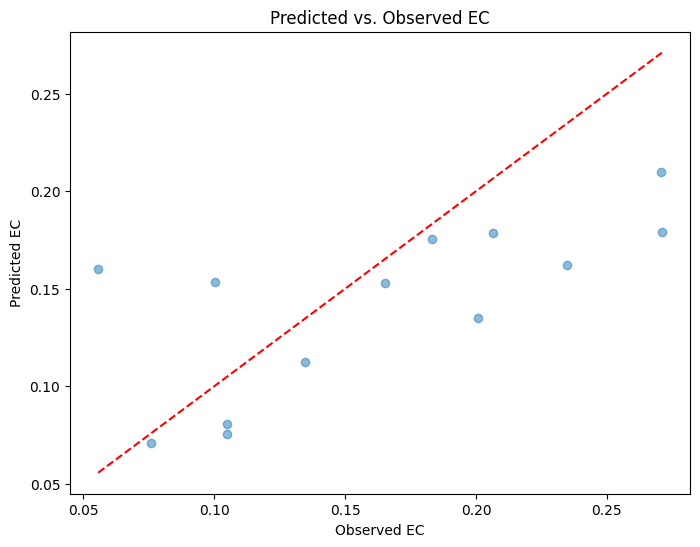

In [ ]:
import pickle
import os

# Save the model from fold 3
if saved_model is not None:
    with open("EC_prediction_model_fold_new.pkl", "wb") as file:
        pickle.dump(saved_model, file)

# Log and visualize results
results_df = pd.DataFrame(fold_results)
print("\nOverall K-Fold Results:\n", results_df)

# Visualize Predicted vs. Observed EC
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_preds, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal line
plt.xlabel("Observed EC")
plt.ylabel("Predicted EC")
plt.title("Predicted vs. Observed EC")
plt.show()

**Predicition for TOC-Total Organic Content**

In [ ]:
# Load the data
extracted_df = pd.read_csv("/content/extracted_data2.csv")

# Set target and selected features
target = "TOC"
selected_features = [
    "ann_ppt", "aspect_cos", "brightness_tc", "carbonate", "clay", "cti",
    "elevation", "fa", "ferrous", "geology", "iron", "lulc", "mean_ndvi",
    "plan_curv", "prof_curv", "slope", "solar_radiation", "lst_median", "wetness"
]

# Drop rows with missing pH values
extracted_df.dropna(subset=[target], inplace=True)

# Fill missing values in features with median
extracted_df[selected_features] = extracted_df[selected_features].fillna(extracted_df[selected_features].median())

# Feature scaling (z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(extracted_df[selected_features])
y = extracted_df[target].values

# Feature importance for pruning
model_temp = RandomForestRegressor(random_state=42)
model_temp.fit(X_scaled, y)
importance_df = pd.DataFrame({"Feature": selected_features, "Importance": model_temp.feature_importances_})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
important_features = importance_df["Feature"].head(15).tolist()

X = extracted_df[important_features]
X = scaler.fit_transform(X)

# K-Fold Cross-Validation
n_splits = 6  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_results = []
saved_model = None

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Hyperparameter tuning within each fold
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Train and evaluate the model
    best_model.fit(X_train, y_train)
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)

    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    fold_results.append({
        'fold': fold + 1,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    })

    if fold + 1 == 5:
        saved_model = best_model

    print(f"Fold {fold + 1}:")
    print(f"  Training R2: {train_r2:.4f}")
    print(f"  Testing R2: {test_r2:.4f}")
    print(f"  Training RMSE: {train_rmse:.4f}")
    print(f"  Testing RMSE: {test_rmse:.4f}")


Fold 1:
  Training R2: 0.7295
  Testing R2: 0.0312
  Training RMSE: 0.5362
  Testing RMSE: 1.5872
Fold 2:
  Training R2: 0.6980
  Testing R2: -0.0159
  Training RMSE: 0.6663
  Testing RMSE: 0.9082
Fold 3:
  Training R2: 0.8624
  Testing R2: -0.0768
  Training RMSE: 0.4399
  Testing RMSE: 1.0076
Fold 4:
  Training R2: 0.8687
  Testing R2: -0.1954
  Training RMSE: 0.4290
  Testing RMSE: 1.0791
Fold 5:
  Training R2: 0.6880
  Testing R2: 0.3892
  Training RMSE: 0.6824
  Testing RMSE: 0.6049
Fold 6:
  Training R2: 0.7259
  Testing R2: -0.1677
  Training RMSE: 0.5916
  Testing RMSE: 1.4152



Overall K-Fold Results:
    fold  train_r2   test_r2  train_rmse  test_rmse
0     1  0.729534  0.031197    0.536206   1.587153
1     2  0.697952 -0.015856    0.666283   0.908216
2     3  0.862398 -0.076826    0.439926   1.007568
3     4  0.868740 -0.195375    0.429015   1.079075
4     5  0.687973  0.389244    0.682379   0.604917
5     6  0.725933 -0.167724    0.591586   1.415204


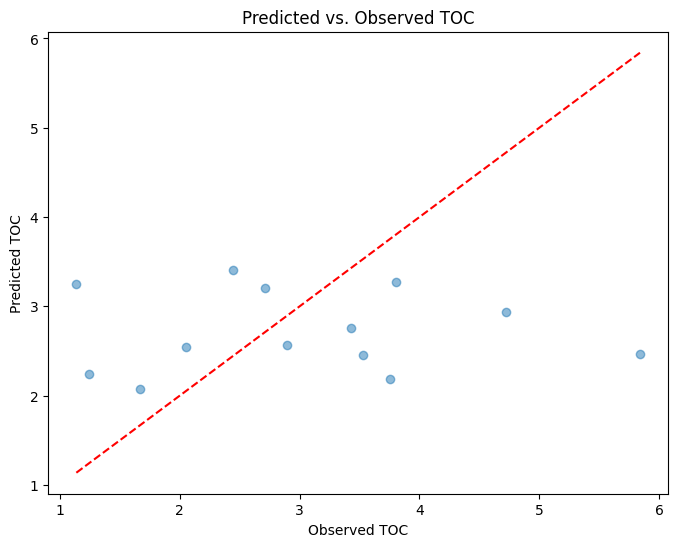

In [ ]:
import pickle
import os

# Save the model from fold 5
if saved_model is not None:
    with open("TOC_prediction_model_fold5_new.pkl", "wb") as file:
        pickle.dump(saved_model, file)

# Log and visualize results
results_df = pd.DataFrame(fold_results)
print("\nOverall K-Fold Results:\n", results_df)

# Visualize Predicted vs. Observed TOC
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_preds, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal line
plt.xlabel("Observed TOC")
plt.ylabel("Predicted TOC")
plt.title("Predicted vs. Observed TOC")
plt.show()

**Predicition for Nitrogen**

In [ ]:
# Load the data
extracted_df = pd.read_csv("/content/extracted_data2.csv")

# Set target and selected features
target = "Nitrogen"
selected_features = [
    "ann_ppt", "aspect_cos", "brightness_tc", "carbonate", "clay", "cti",
    "elevation", "fa", "ferrous", "geology", "iron", "lulc", "mean_ndvi",
    "plan_curv", "prof_curv", "slope", "solar_radiation", "lst_median", "wetness"
]

# Drop rows with missing pH values
extracted_df.dropna(subset=[target], inplace=True)

# Fill missing values in features with median
extracted_df[selected_features] = extracted_df[selected_features].fillna(extracted_df[selected_features].median())

# Feature scaling (z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(extracted_df[selected_features])
y = extracted_df[target].values

# Feature importance for pruning
model_temp = RandomForestRegressor(random_state=42)
model_temp.fit(X_scaled, y)
importance_df = pd.DataFrame({"Feature": selected_features, "Importance": model_temp.feature_importances_})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
important_features = importance_df["Feature"].head(15).tolist()

X = extracted_df[important_features]
X = scaler.fit_transform(X)

# K-Fold Cross-Validation
n_splits = 6  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_results = []
saved_model = None

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Hyperparameter tuning within each fold
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Train and evaluate the model
    best_model.fit(X_train, y_train)
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)

    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    fold_results.append({
        'fold': fold + 1,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    })

    if fold + 1 == 4:
        saved_model = best_model

    print(f"Fold {fold + 1}:")
    print(f"  Training R2: {train_r2:.4f}")
    print(f"  Testing R2: {test_r2:.4f}")
    print(f"  Training RMSE: {train_rmse:.4f}")
    print(f"  Testing RMSE: {test_rmse:.4f}")



Fold 1:
  Training R2: 0.8820
  Testing R2: 0.1604
  Training RMSE: 0.0245
  Testing RMSE: 0.1156
Fold 2:
  Training R2: 0.7306
  Testing R2: 0.1431
  Training RMSE: 0.0464
  Testing RMSE: 0.0559
Fold 3:
  Training R2: 0.8665
  Testing R2: 0.1563
  Training RMSE: 0.0309
  Testing RMSE: 0.0772
Fold 4:
  Training R2: 0.7247
  Testing R2: 0.3868
  Training RMSE: 0.0467
  Testing RMSE: 0.0484
Fold 5:
  Training R2: 0.7243
  Testing R2: 0.2692
  Training RMSE: 0.0460
  Testing RMSE: 0.0597
Fold 6:
  Training R2: 0.8522
  Testing R2: 0.0203
  Training RMSE: 0.0337
  Testing RMSE: 0.0706



Overall K-Fold Results:
    fold  train_r2   test_r2  train_rmse  test_rmse
0     1  0.881988  0.160395    0.024480   0.115558
1     2  0.730550  0.143095    0.046441   0.055935
2     3  0.866510  0.156299    0.030925   0.077163
3     4  0.724658  0.386798    0.046712   0.048362
4     5  0.724251  0.269171    0.046022   0.059711
5     6  0.852191  0.020254    0.033738   0.070578


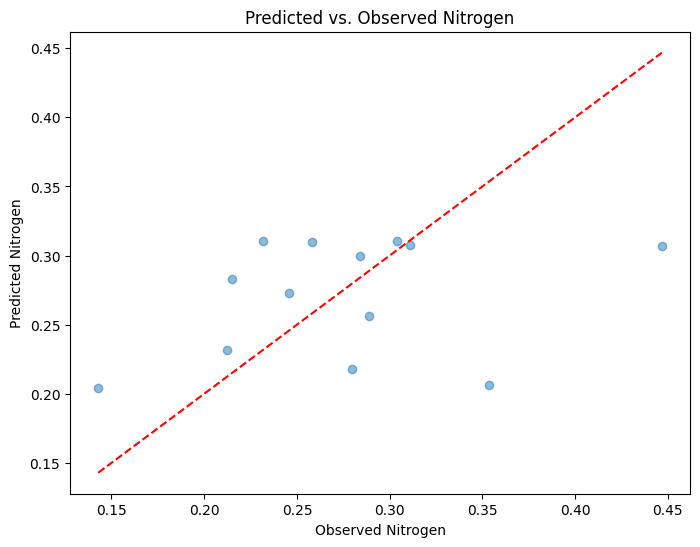

In [ ]:
import pickle
import os

# Save the model from fold 4
if saved_model is not None:
    with open("Nitrogen_prediction_model_fold_new4.pkl", "wb") as file:
        pickle.dump(saved_model, file)

# Log and visualize results
results_df = pd.DataFrame(fold_results)
print("\nOverall K-Fold Results:\n", results_df)

# Visualize Predicted vs. Observed TOC
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_preds, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal line
plt.xlabel("Observed Nitrogen")
plt.ylabel("Predicted Nitrogen")
plt.title("Predicted vs. Observed Nitrogen")
plt.show()

In [ ]:
import os
# Raster prediction using saved model
stack_output_path = "/content/data/reprojected/covariate_stack.tif"  # Update with your raster stack path
output_dir = "/content/output"  # Update with desired output path

# Load the saved model for prediction
with open("Nitrogen_prediction_model_fold_new4.pkl", "rb") as file:
    loaded_model = pickle.load(file)

# Prepare the covariates for prediction
with rasterio.open(stack_output_path) as src:
    profile = src.profile
    covariate_stack = src.read()
    covariate_stack = np.transpose(covariate_stack, (1, 2, 0))
    covariates = covariate_stack.reshape(-1, covariate_stack.shape[2])

    # Select important features for prediction
    covariates = covariates[:, [selected_features.index(feature) for feature in important_features]]

    covariates = np.clip(covariates, -1e6, 1e6)
    covariates = np.nan_to_num(covariates, nan=np.nanmedian(covariates))
    covariates[np.isinf(covariates)] = np.nanmedian(covariates)

    covariates_scaled = scaler.transform(covariates)

    predictions = loaded_model.predict(covariates_scaled)
    prediction_raster = predictions.reshape(covariate_stack.shape[:2])

    profile.update(dtype=rasterio.float32, count=1, compress='lzw')
    output_raster_path = os.path.join(output_dir, "predicted_Nitrogen_output1.tif")
    with rasterio.open(output_raster_path, "w", **profile) as dst:
        dst.write(prediction_raster.astype(rasterio.float32), 1)

print(f"Nitrogen predictions saved to {output_raster_path}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Nitrogen predictions saved to /content/output/predicted_Nitrogen_output1.tif


**Comparing Different models**

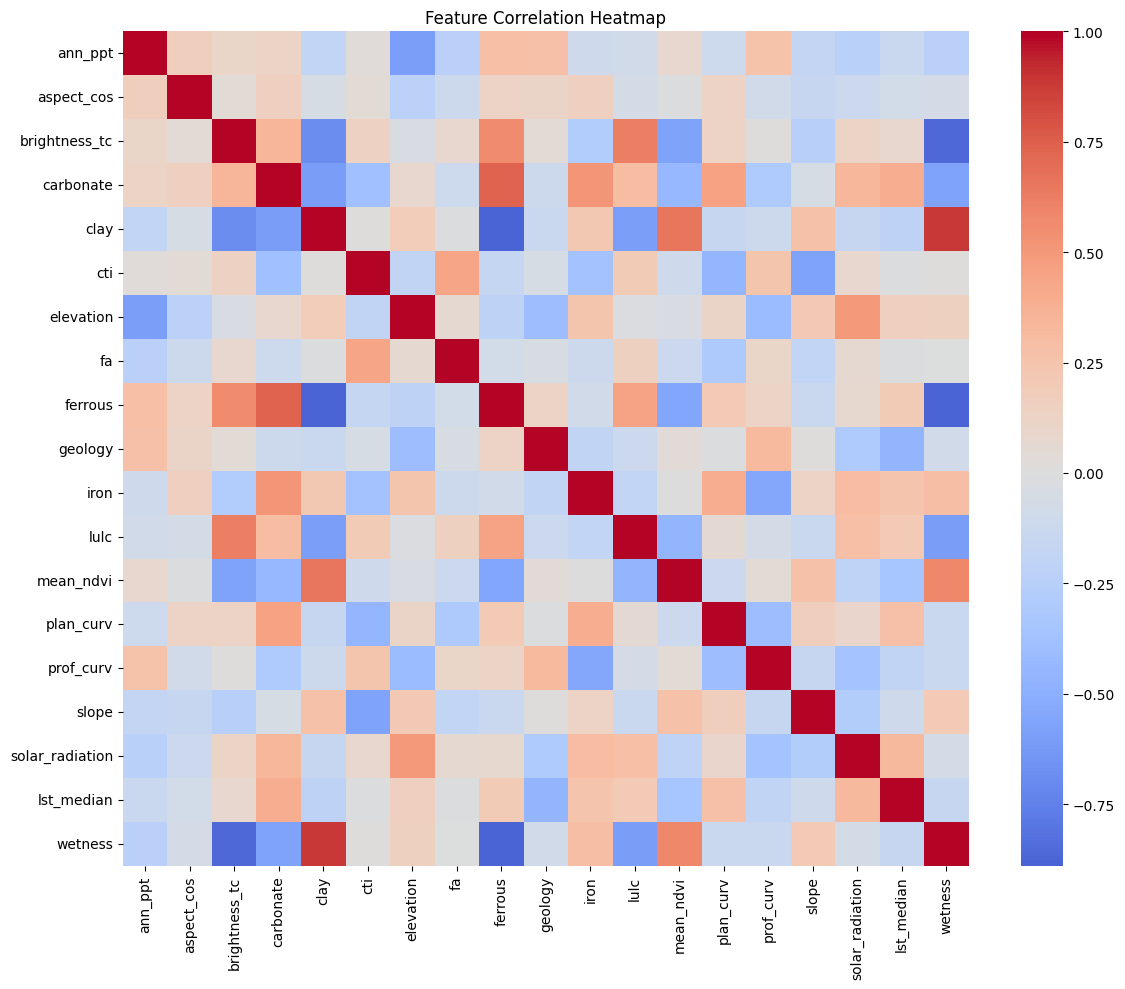

Explained variance ratio (first 5 PCs): [0.26680103 0.18311085 0.13034236 0.0790137  0.05444779]


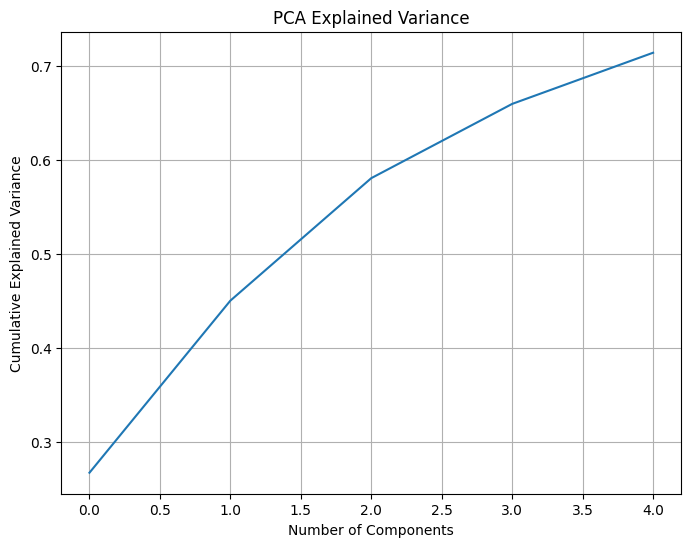

Top RFE-selected features: ['brightness_tc', 'clay', 'cti', 'fa', 'ferrous', 'iron', 'lulc', 'plan_curv', 'solar_radiation', 'wetness']

Model Performance Comparison:
                  Training R2  Testing R2  Training RMSE  Testing RMSE
ElasticNet              0.126       0.207          0.627         0.588
Ridge                   0.270       0.329          0.573         0.541
LinearRegression        0.219       0.285          0.593         0.558


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.86836e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [ ]:
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.decomposition import PCA

# Remove near-zero variance features
selector = VarianceThreshold(threshold=1e-5)
X_filtered = selector.fit_transform(extracted_df[features])
filtered_features = [feature for feature, keep in zip(features, selector.get_support()) if keep]

# Correlation heatmap
corr_matrix = extracted_df[filtered_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# PCA Analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(extracted_df[filtered_features])
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio (first 5 PCs):", pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

# Recursive Feature Elimination
rfe_model = LinearRegression()
rfe = RFE(rfe_model, n_features_to_select=10)
rfe.fit(X_scaled, extracted_df[target])
rfe_features = [feature for feature, selected in zip(filtered_features, rfe.support_) if selected]
print("Top RFE-selected features:", rfe_features)

# Final model comparison table setup
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    return {
        "Training R2": r2_score(y_train, train_preds),
        "Testing R2": r2_score(y_test, test_preds),
        "Training RMSE": np.sqrt(mean_squared_error(y_train, train_preds)),  # Calculate RMSE manually
        "Testing RMSE": np.sqrt(mean_squared_error(y_test, test_preds))  # Calculate RMSE manually
    }


X_final = extracted_df[rfe_features]
X_train, X_test, y_train, y_test = train_test_split(X_final, extracted_df[target], test_size=0.3, random_state=42)

results = {
    "ElasticNet": evaluate_model(ElasticNet(), X_train, X_test, y_train, y_test),
    "Ridge": evaluate_model(Ridge(alpha=10.0), X_train, X_test, y_train, y_test),
    "LinearRegression": evaluate_model(LinearRegression(), X_train, X_test, y_train, y_test)
}

results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df.round(3))
